In [1]:
import os
os.chdir("../LSTM")

In [2]:
from core.nn.LSTM_M2 import LSTM_M2

%load_ext autoreload
%autoreload 2

from SIR_ODE import SIR
import math
import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import requests, io, json, urllib
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle
import os.path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
from sklearn.metrics import mean_squared_error
from itertools import cycle

import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
def get_periods(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))
    

def plot_param(df, periods, TARGET):
    fig = px.line(df, x="Date", y=TARGET, title='Lockdown periods in ' + COUNTRY)
    for dates in periods:
        fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
    fig.show()

def add_bias(results, BIAS, isBias=True):
    data = results.copy()
    preds = []
    SIR_data = []
    dates = []
    x_dates, x_preds, total_dates = [], [], []
    x_plot_preds = []
    
    # START Adding bias after days_delay
    BIAS_START = DELAY_START + datetime.timedelta(days_delay)
    for date, pred, index in zip(data["valData"]["Date"], data["pred"], range(0, len(data["valData"]))):
        if date >= BIAS_START:
            preds.append(pred)
            dates.append(date)
            SIR_data.append(SIR_results["I"][index])
        x_dates.append(date)
        x_preds.append(pred)
        total_dates.append(date)
     # Add bias to prediction
    # Calculate trend in SIR-predictions
    x = np.arange(0,len(SIR_data))
    y = np.array(SIR_data)
    if len(y) > 1:
        z = np.polyfit(x, y, 1)[0]
    else:
        z = 1
        
    new_preds, old_preds = [], []
    weight = 3
    for i in range(len(preds)):
        if i == len(preds) - 1:
            diff = preds[i] - preds[i-1]
        else:
            diff = preds[i + 1] - preds[i]
        percent = (i+1) / days_delay
        weight += 0.1
        if isBias:
            new_trend = (percent * z/weight + diff)
            new_trend = new_trend + diff
            new_preds.append(preds[i] + new_trend)
        else:
            new_preds.append(preds[i])
        old_preds.append(preds[i])

    if len(y) <= 1:
        new_preds = data["pred"]
    combined_new_preds = new_preds
#     plt.plot(combined_new_preds)
#     plt.show()
    # Add data to results
    data["total_old_pred"] = data["pred"]
    data["pred"] = combined_new_preds
    data["oldpred"] = old_preds
    return data


In [4]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
population_df = population_data.cleaned()
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


In [5]:
COUNTRY = "Italy"
TARGET_NPI = "Stringency_index"
FACTOR = 5

In [112]:
NPI_df = oxcgrt_data.cleaned()
NPI_df = NPI_df[NPI_df["Country"] == COUNTRY]

# Get lockdown dates
NPI_df = NPI_df.reset_index().drop('index', axis=1)
NPI_df = NPI_df.groupby("Date").mean().reset_index()

s = cs.Scenario(jhu_data, population_data, country=COUNTRY)
days_delay, df_periods = s.estimate_delay(oxcgrt_data)
print(f'Delay days: {days_delay}')

NPI = TARGET_NPI
NPI_dates = {}
min_rate = 75
periods = []
while periods == [] or min_rate < 1:
    lockdown_indexes = NPI_df[NPI_df[NPI] >= min_rate].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= min_rate]["Date"]
    periods = get_periods(lockdown_indexes)
    min_rate -= 1
print(periods)
lockdown_dates_adjusted = []
for date in lockdown_dates:
    new_date = date + datetime.timedelta(days = days_delay)
    lockdown_dates_adjusted.append(new_date)
NPI_dates[NPI] = lockdown_dates_adjusted
lockdown_dates_adjusted = pd.Series(lockdown_dates_adjusted) 

DELAY_START = NPI_df.iloc[periods[1][0] + days_delay].Date
index = -1
while DELAY_START >= pd.to_datetime("2021-03-01"):
    DELAY_START = NPI_df.iloc[periods[-index][0]].Date
    index -= 1
if COUNTRY == "Italy":
    DELAY_START = pd.to_datetime('2020-12-21')
print(DELAY_START)

if COUNTRY == "United Kingdom":
    df_params = pd.read_pickle("df_United_Kingdom")
elif COUNTRY == "Sweden":
    df_params = pd.read_pickle("../figures/pickles/df_Sweden")
elif COUNTRY == "United States":
    df_params = pd.read_pickle("../figures/pickles/df_United_States")
else:
    df_params = pd.read_pickle("../figures/pickles/df_9_countries")
df_params["Country"].unique()
df_params = df_params[df_params["Country"] == COUNTRY]

Delay days: 15
[(69, 123), (310, 447)]
2020-12-21 00:00:00


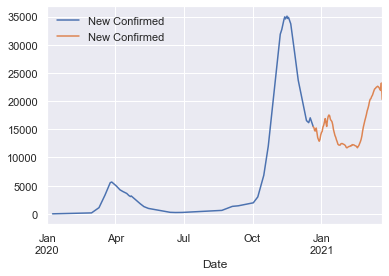

In [157]:
df = jhu_data.cleaned()
df = df[df["Country"] == COUNTRY]
old_df = df.copy()
df = df[df["Province"] == "-"]
df[df.columns[-4:]] = df[df.columns[-4:]].rolling(7).mean()
df["New Confirmed"] = df.Confirmed.diff()
train = df[df["Date"] <= DELAY_START.strftime("%Y-%m-%d")]
test = df[df["Date"] >= DELAY_START.strftime("%Y-%m-%d")]
ax = train.plot(x="Date", y="New Confirmed");
test.plot(x="Date", y="New Confirmed", ax=ax);

## SIR Model

In [114]:
selection = train.iloc[-1]
N = population_df[population_df["Country"] == COUNTRY]["Population"].values[0]
print('Population in', COUNTRY, ":", N)

Population in Italy : 60421760


In [181]:
target_column = "Infected"

def calc_param(df, lockdown_dates):
    total_params = ["theta", "kappa", "rho", "sigma"]
    calc_params_df = {}
    for param in total_params:
        values = []
        for date in df["Date"].values:
            if date in lockdown_dates.values:
                values.append(np.mean(df[df['Date'] == date][param]))
        calc_params_df[param] = np.mean(values)
    return calc_params_df

params_total = {}
sir_params_total = {}
for p in NPI_dates:
    res = calc_param(df_params, pd.Series(NPI_dates[p]))
    if not math.isnan(res["kappa"]):
        params_total[p] = res
        sir = SIR(N=N, I0=selection[target_column], R0=selection["Recovered"], 
                  beta=res["rho"], gamma=res["theta"], days=len(test))
        SIR_results = sir.simulate(target="Infected", plot=False)
        sir_params_total[p] = SIR_results
test["SIR Infected lockdown scenario"] = SIR_results["I"]

## LSTM predictions

In [155]:
SIR_LSTM = LSTM_M2(COUNTRY, DELAY_START, FUTURE_DAYS=len(test))
SIR_LSTM.input_data(df)
results = SIR_LSTM.simulate();

0.2179781049489975


### Plot prediction values of M2

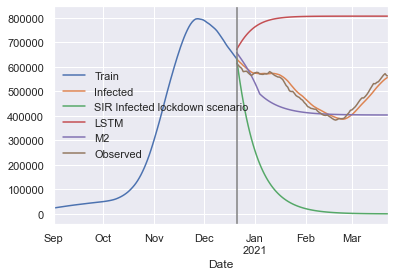

In [180]:
test["LSTM"] = results["pred"]
test["M2"] = SIR_LSTM.update_predictions(test["SIR Infected lockdown scenario"], tau=days_delay)
test["Observed"] = old_df[old_df["Date"] >= DELAY_START.strftime("%Y-%m-%d")]["Infected"]
ax = train_copy.plot(x="Date", y="Infected", label="Train");
test.plot(x="Date", y=["Infected", "SIR Infected lockdown scenario", "LSTM", "M2", "Observed"], ax=ax);
ax.axvline(x=DELAY_START.strftime("%Y-%m-%d"), color="grey");
